In [541]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import pifos
import pifos.models.abstract as pma
import pifos.criteria.elbo as elbo
import pifos.criteria.generalized as gen
reload(pma)
reload(elbo)
reload(gen)
use_cuda = True
# todo: cuda
# todo check

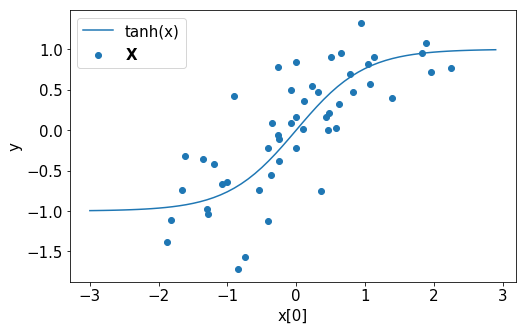

In [550]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 15
rs = np.random.RandomState(42)
X = rs.randn(50)
means = np.mean(X)#.reshape(1,-1)
stds = np.std(X)#.reshape(1, -1)
X = (X-means)/(stds)

#X = np.vstack([X, X**2,X**3, X**4, X**5, X**6, X**7, X**8, X**9, np.exp(X), np.log(np.abs(X))]).T
X = np.vstack([X]+[rs.randn(X.shape[0]) for _ in range(10)]).T

Y = np.tanh(X[:,0]) +rs.randn(X.shape[0])*.5 

plt.scatter(X[:,0],Y,label='$\mathbf{X}$')
plt.plot(np.arange(-3,3, 0.1), np.tanh(np.arange(-3,3,0.1)), label='tanh(x)')


X_tensor = t.Tensor(X)
Y_tensor = t.Tensor(Y).view(-1, 1)
if use_cuda:
    X_tensor = X_tensor.cuda()
    Y_tensor = Y_tensor.cuda()
Y.shape
plt.xlabel('x[0]')
plt.ylabel('y')
plt.legend(loc='best')
plt.savefig('./dataset.png')

In [551]:
class SimpleModel(pma.StructureVarModel):
    def __init__(self, l_temp):
        pma.StructureVarModel.__init__(self)
        
        self.h_log_sigma = nn.Parameter(t.Tensor(np.ones(15)*(-0.0)))        
        self.h_gamma =  nn.Parameter(t.Tensor(np.random.randn(3)*.1+1))
        self.h_log_y_eps =  nn.Parameter(t.Tensor(np.zeros(1))) # matrix B in Bishop's notation
        self.h = [self.h_gamma, self.h_log_sigma, self.h_log_y_eps]
        
        
        self.theta_mean  = nn.Parameter(t.Tensor(np.random.randn(15, 1)*0.1))
        self.theta_log_sigma  = nn.Parameter(t.Tensor(np.ones((15,1)))*(-0.0))
        self.theta_gamma = nn.Parameter(t.Tensor(np.random.randn(3)*.1+1))
        self.theta_temp = nn.Parameter(t.Tensor(np.ones(1)))
        self.theta['qw'] = [self.theta_mean,self.theta_log_sigma]
        self.theta['qG'] = [self.theta_gamma, self.theta_temp] 
        
        # for gaussian sampling
        
        self.eps = t.distributions.Normal(t.zeros(self.theta_mean.shape), t.ones(self.theta_mean.shape))
        self.l_temp = l_temp
        self.use_cuda = False
        
    def cuda(self):
        pma.StructureVarModel.cuda(self)
        for i, p in enumerate(self.h):
            self.h[i] = p.cuda()
        for k in self.theta:
            for i,p in enumerate(self.theta[k]):
                self.theta[k][i] = p.cuda()
        self.l_temp = self.l_temp.cuda()
        self.eps = t.distributions.Normal(t.zeros(self.theta_mean.shape).cuda(),
                                          t.ones(self.theta_mean.shape).cuda())
        
        
        
    def q_gamma(self):
        return t.distributions.RelaxedOneHotCategorical(self.theta_temp, logits=self.theta_gamma)
    
    def prior_gamma(self):    
        return t.distributions.RelaxedOneHotCategorical(t.tensor(self.l_temp), logits=self.h_gamma)
           
    def q_mean(self):
        w =  self.theta_mean * 1.0
        sample = self.q_gamma()
        w[:12] *= sample[0]
        w[12:14] *= sample[1]
        w[14] *= sample[2]
        return w
        
    def q_w(self):
        
        # i'm using old version of pytorch, there is some issue with params in distributions
        
        return self.theta_mean + t.exp(self.theta_log_sigma)*self.eps.sample()
       
    
    def forward(self, x):               
        
        gs_sample = self.q_gamma().rsample()     
        gaussian_sample = self.eps.sample()            
        w = self.q_w()
     
    
        dot1 = t.tanh(t.mm(x,w[:11])+w[11])

        dot2 = t.tanh(t.mm(x[:, :1],w[12:13])+w[13])
        dot3 = 0*x[:,:1] + w[14]
        
        return gs_sample[0]*dot1 + gs_sample[1]*dot2 + gs_sample[2]*dot3
        #
   

In [740]:
!rm *.png

In [753]:
warm = True
i = 0
def experiment(temp, l_ll, l_prior, iter_num = 2000, model_num = 5, sample_num=10):
    global warm, i
    warm = True
    models = []
    l__temp = t.tensor(temp)
    while len(models)!=model_num:
    


        net = SimpleModel(l__temp)
        #REMOVE ME
        #net.theta_mean.data*=0
        #A = 10.0
        #net.theta_gamma.data= t.tensor([1.0,A,1.0])
        #net.h_gamma.data= t.tensor([1.0,A,1.0])
        #net.theta['qG'].remove(net.theta_gamma)
        #net.h.remove(net.h_gamma)
        ##########
        kld_zeros =  t.zeros(net.theta_mean.shape[0], 1)
    
        if use_cuda:    
            net.cuda()
            kld_zeros = kld_zeros.cuda()
        
        lim = t.ones(1)*(-4.0)
        if use_cuda:
                lim = lim.cuda()
                
        def ll(Y,Y0, model):            
            return elbo.neg_log_ll_regression(Y.view(-1), Y0.view(-1), model.h_log_y_eps)

        def kld(model):
            prior_gamma_sample = model.prior_gamma().rsample()
           
            prior_sigma = model.h_log_sigma*1.0
            # remove me
            global warm, i
            if not warm:
                prior_sigma[:12]+= t.log(prior_gamma_sample[0])
                prior_sigma[12:14]+=t.log(prior_gamma_sample[1])
                prior_sigma[14]+=t.log(prior_gamma_sample[2])
                
           
                
            #True
            
            prior_sigma = t.max(prior_sigma, lim)

            q_sigma = t.max(model.theta_log_sigma, lim)
            

            gamma_kld = elbo.kld_gs( model.q_gamma(),
                                     model.prior_gamma(),    1)
            ids = range(15)
            weights = t.ones(15).cuda()
            _zeros = kld_zeros*1.0
            #if not warm:
               
                #zeros[:12] += model.theta_mean[:12]*prior_gamma_sample[0]
                #_zeros[12:14] += model.theta_mean[12:14]*prior_gamma_sample[1]
                #_zeros[14] += model.theta_mean[14]*prior_gamma_sample[2]
                #weights[:12] = (prior_gamma_sample[0])
                #weights[12:14] = (prior_gamma_sample[1])
                #weights[14] = (prior_gamma_sample[2])
            
            norm_kld = elbo.kld_diag(model.theta_mean[ids],
                                    _zeros, 2*q_sigma[ids], 2*prior_sigma[ids]) 
            
          
        
            ### REMOVE ME
            #G = 2.0#.0001
            #gamma = 1.0*t.distributions.Gamma(t.tensor([G]).cuda(), t.tensor([G]).cuda()).log_prob(t.exp(model.h_log_sigma)).sum()
            
            return (gamma_kld + norm_kld)# - gamma) 

        def criterion(Y, Y0, model):              
            return gen.generalized_one_level(Y, Y0, nll=lambda y,y0: ll(y, y0, model), kld= lambda: kld(model), 
                                             c_ll = l_ll, c_prior = l_prior,)

        

        optimizer = t.optim.Adam(net.h + net.theta['qw'] + net.theta['qG'], lr=0.01)
    

        for i in range(iter_num):
            if i==500:
                warm = False
                net.h_log_sigma.data = t.ones(15).cuda()*(10.0)
                
            loss = 0
            optimizer.zero_grad()

            for _ in range(sample_num):
                out = net(X_tensor)

                loss += criterion(out, Y_tensor.view(Y_tensor.shape[0],1), net)/sample_num
            
            loss.backward()#retain_graph=False)
            #print net.theta_gamma.grad
            t.nn.utils.clip_grad.clip_grad_norm_(net.theta['qw'] + net.theta['qG']+ net.h, 1.0)
            if i%100 == 0:
                print i, loss 
                print 'Q', net.q_gamma().probs
                print 'H',net.prior_gamma().probs
                #print 'TETA', net.theta_mean[12:14]
                #print 'G', net.theta['qG'][0].grad
            optimizer.step()
        if not t.isnan(loss):
            models.append(net)
        
    return models



In [804]:
#### 1 sample
result = experiment(10.0, 100.0, 1.00, iter_num=1001, sample_num=3, model_num=10)
print result[0].theta
print result[0].h
print result[0].prior_gamma().probs

0 tensor([7142.0830], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.3325, 0.3113, 0.3563], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.3483, 0.3137, 0.3379], device='cuda:0', grad_fn=<SoftmaxBackward>)
100 tensor([6005.6016], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.2675, 0.4128, 0.3197], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.3116, 0.2945, 0.3939], device='cuda:0', grad_fn=<SoftmaxBackward>)
200 tensor([3096.7468], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.1330, 0.7735, 0.0934], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.2163, 0.5989, 0.1847], device='cuda:0', grad_fn=<SoftmaxBackward>)
300 tensor([2663.1113], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.1969, 0.7672, 0.0359], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.0683, 0.9147, 0.0170], device='cuda:0', grad_fn=<SoftmaxBackward>)
400 tensor([2198.7192], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.4843, 0.4964, 0.0193], devic

400 tensor([2364.9775], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.3192, 0.6668, 0.0140], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.0758, 0.9230, 0.0012], device='cuda:0', grad_fn=<SoftmaxBackward>)
500 tensor([2202.0471], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.6426, 0.3485, 0.0089], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.1384, 0.8613, 0.0003], device='cuda:0', grad_fn=<SoftmaxBackward>)
600 tensor([2248.2927], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.7959, 0.1987, 0.0054], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.1733, 0.8266, 0.0001], device='cuda:0', grad_fn=<SoftmaxBackward>)
700 tensor([2103.4121], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.8556, 0.1406, 0.0038], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.2718, 0.7281, 0.0001], device='cuda:0', grad_fn=<SoftmaxBackward>)
800 tensor([2027.2356], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.9077, 0.0901, 0.0022], dev

800 tensor([2097.3379], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.9238, 0.0740, 0.0021], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.7779, 0.2219, 0.0001], device='cuda:0', grad_fn=<SoftmaxBackward>)
900 tensor([1993.6726], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.9542, 0.0445, 0.0013], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.9142, 0.0857, 0.0001], device='cuda:0', grad_fn=<SoftmaxBackward>)
1000 tensor([2080.7224], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.9731, 0.0260, 0.0009], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.9688, 0.0312, 0.0000], device='cuda:0', grad_fn=<SoftmaxBackward>)
0 tensor([8553.7871], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.3676, 0.3436, 0.2888], device='cuda:0', grad_fn=<SoftmaxBackward>)
H tensor([0.3325, 0.3238, 0.3438], device='cuda:0', grad_fn=<SoftmaxBackward>)
100 tensor([4409.1440], device='cuda:0', grad_fn=<ThAddBackward>)
Q tensor([0.2422, 0.5488, 0.2091], devi

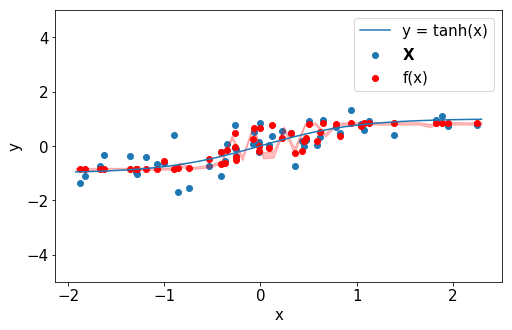

tensor([0.9717, 0.0273, 0.0010], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9728, 0.0263, 0.0010], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9689, 0.0300, 0.0010], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9655, 0.0336, 0.0009], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9750, 0.0240, 0.0010], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9737, 0.0255, 0.0009], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9732, 0.0259, 0.0009], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9730, 0.0260, 0.0010], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9694, 0.0296, 0.0010], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.9763, 0.0227, 0.0009], device='cuda:0', grad_fn=<SoftmaxBackward>)


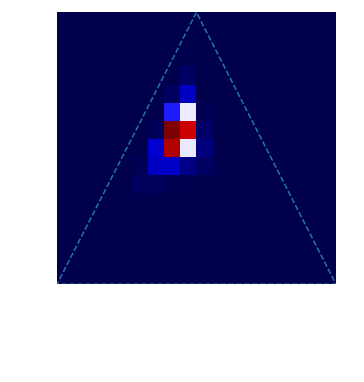

In [805]:
name = '10.0overfit'
make_plot(result,'plot_'+name+'.png')
plt.show()
make_triangle(result, 'triangle_'+name+'.png')
plt.show()
#make_barplot(result, 'bar_'+name+'.png')

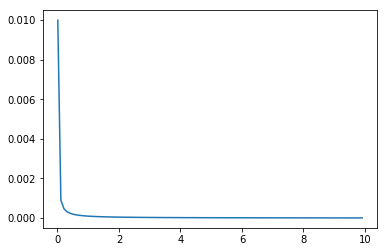

In [305]:
import scipy.stats as st
x = np.arange(0.01, 10.0, 0.1).reshape(-1, 1)
G = 10.0**(-4)
H = 10.0**(-4)
plt.plot(x, np.exp(t.distributions.Gamma(t.tensor(G), t.tensor(H)).log_prob(t.tensor(x, dtype=t.float32)).detach().numpy()))


In [409]:
model = result[0]
kld_zeros =  t.zeros(model.theta_mean.shape[0], 1)

if use_cuda:    
    model.cuda()
    kld_zeros = kld_zeros.cuda()

lim = t.ones(1)*(-2.0)
if use_cuda:
        lim = lim.cuda()
def kld(model):
            prior_gamma_sample = model.prior_gamma().rsample()
            prior_sigma = model.h_log_sigma*1.0
            # remove me
            #prior_sigma[:12]+= t.log(prior_gamma_sample[0])*0.5
            #prior_sigma[:2]=prior_sigma[:2] + t.log(prior_gamma_sample[0])*0.5
            #prior_sigma[12:14]+=t.log(prior_gamma_sample[1])*0.5
            #prior_sigma[14]+=t.log(prior_gamma_sample[2])*0.5
            prior_sigma = t.max(prior_sigma, lim)

            q_sigma = t.max(model.theta_log_sigma, lim)
            

            gamma_kld = elbo.kld_gs( model.q_gamma(),
                                     model.prior_gamma(),    1)
            
            norm_kld = elbo.kld_diag(model.theta_mean,
                                    kld_zeros, 2*q_sigma, 2*prior_sigma)  
            
            return (gamma_kld + norm_kld)


In [54]:
kld(model)

tensor([106.9971], device='cuda:0', grad_fn=<ThAddBackward>)

In [28]:
model = result[0]

In [13]:
prior_gamma_sample = model.prior_gamma().rsample()
prior_sigma = model.h_log_sigma*1.0
# remove me
prior_sigma[:12]+= t.log(prior_gamma_sample[0])*0.5
#prior_sigma[:2]=prior_sigma[:2] + t.log(prior_gamma_sample[0])*0.5
prior_sigma[12:14]+=t.log(prior_gamma_sample[1])*0.5
prior_sigma[14]+=t.log(prior_gamma_sample[2])*0.5
prior_sigma = t.max(prior_sigma, lim)

q_sigma = t.max(model.theta_log_sigma, lim)


gamma_kld = elbo.kld_gs( model.q_gamma(),
                         model.prior_gamma(),    1)

                     
ids = range(15)
norm_kld = elbo.kld_diag(model.theta_mean[ids],
                        kld_zeros[ids], 2*q_sigma[ids], 2*prior_sigma[ids])

print model.theta_mean, prior_sigma, q_sigma
(gamma_kld, norm_kld)

NameError: name 'model' is not defined

In [242]:
prior_gamma_sample = t.zeros(3).cuda()+0.01
prior_sigma[2] += 0.98
# remove me
prior_sigma[:12]+= t.log(prior_gamma_sample[0])*0.5
prior_sigma[12:14]+=t.log(prior_gamma_sample[1])*0.5
prior_sigma[14]+=t.log(prior_gamma_sample[2])*0.5
prior_sigma = t.max(prior_sigma, lim)

q_sigma = t.max(model.theta_log_sigma, lim)


gamma_kld = elbo.kld_gs( model.q_gamma(),
                         model.prior_gamma(),    1)
ids = range(15)
norm_kld = elbo.kld_diag(model.theta_mean[ids],
                        kld_zeros[ids], 2*q_sigma[ids], 2*prior_sigma[ids])

print model.theta_mean, prior_sigma, q_sigma
(gamma_kld, norm_kld)

Parameter containing:
tensor([[-1.3713e-03],
        [-3.6996e-03],
        [ 1.4969e-05],
        [-7.2621e-04],
        [ 7.4717e-04],
        [ 1.1463e-04],
        [-1.4463e-05],
        [ 5.5589e-04],
        [ 6.9477e-04],
        [-3.2540e-04],
        [ 4.5898e-06],
        [-1.7177e-04],
        [ 8.2815e-05],
        [-6.1317e-06],
        [ 9.6195e-06]], device='cuda:0', requires_grad=True) tensor([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2.], device='cuda:0', grad_fn=<MaxBackward2>) tensor([[-1.9971],
        [-1.9969],
        [-1.9972],
        [-1.9972],
        [-1.9966],
        [-1.9971],
        [-1.9971],
        [-1.9971],
        [-1.9971],
        [-1.9972],
        [-1.9972],
        [-1.9971],
        [-1.9781],
        [-1.9781],
        [-1.9819]], device='cuda:0', grad_fn=<MaxBackward2>)


(tensor([-0.0281], device='cuda:0', grad_fn=<AddBackward>),
 tensor(0.0019, device='cuda:0', grad_fn=<MulBackward>))

In [600]:
model.h

[Parameter containing:
 tensor([1., 1., 1.], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3.], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3.1843], device='cuda:0', requires_grad=True)]

In [362]:
model.q_gamma().sample()

sum([model.q_gamma().log_prob(model.q_gamma().sample()) - model.prior_gamma().log_prob(model.q_gamma().sample()) for _ in range(1000)])/1000
#model.q_gamma().temperature

tensor([0.3624], device='cuda:0', grad_fn=<DivBackward0>)

In [539]:
def make_plot(models, title=None):
    plt.rcParams['figure.figsize'] = (8,5)
    plt.rcParams['font.size'] = 15
    plt.xlabel('x')
    plt.ylabel('y')
    
    x = np.arange(-2, 2, 0.1)
    x = (x-means)/stds
    x = np.vstack([x] +[rs.randn(x.shape[0]) for _ in range(10)]).T
    


    x = t.Tensor(x)
    if use_cuda:
        x = x.cuda()


    plt.scatter(X[:,0],Y, label='$\mathbf{X}$')
    ys = []
    ys2 = []
    for net in models:
        for s in range(100):
            ys.append(net.forward(x).cpu().detach().numpy())

        for s in range(100):
            ys2.append(net.forward(X_tensor).cpu().detach().numpy())

    plt.fill_between(x[:,0].cpu().detach().numpy(), y1=(np.mean(ys, axis=0)-np.std(ys, axis=0)).flatten(),
                     y2=(np.mean(ys, axis=0)+np.std(ys, axis=0)).flatten(), alpha=0.25, color='r')

    plt.scatter(X[:,0], (np.mean(ys2, axis=0)).flatten(), color='r', label='f(x)')

    plt.plot(x[:,0].cpu().detach().numpy(), np.tanh(x[:,0].cpu().detach().numpy()), label='y = tanh(x)')
    plt.legend(loc='best')
    plt.ylim(-5,5)
    if title:
        plt.savefig(title, bbox_inches='tight')

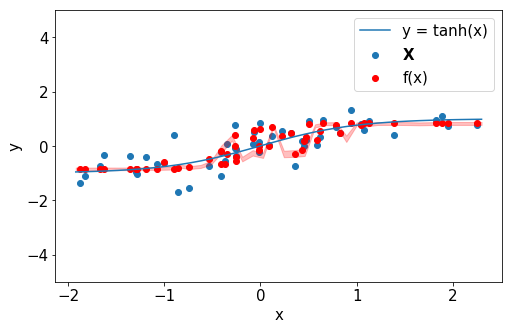

In [540]:
make_plot(result)

In [494]:
# https://github.com/bmechtley/barycentric/blob/master/barycentric/coordinates.py
def polycorners(ncorners=3):
    '''
    Return 2D cartesian coordinates of a regular convex polygon of a specified
    number of corners.
    Args:
        ncorners (int, optional) number of corners for the polygon (default 3).
    Returns:
        (ncorners, 2) np.ndarray of cartesian coordinates of the polygon.
    '''

    center = np.array([0.5, 0.5])
    points = []

    for i in range(ncorners):
        angle = (float(i) / ncorners) * (np.pi * 2) + (np.pi / 2)
        x = center[0] + np.cos(angle) * 0.5
        y = center[1] + np.sin(angle) * 0.5
        points.append(np.array([x, y]))

    return np.array(points)

def bary2cart(bary, corners=None):
    '''
    Convert barycentric coordinates to cartesian coordinates given the
    cartesian coordinates of the corners.
    Args:
        bary (np.ndarray): barycentric coordinates to convert. If this matrix
            has multiple rows, each row is interpreted as an individual
            coordinate to convert.
        corners (np.ndarray): cartesian coordinates of the corners.
    Returns:
        2-column np.ndarray of cartesian coordinates for each barycentric
        coordinate provided.
    '''

    if corners == None:
        corners = polycorners(bary.shape[-1])

    cart = None

    if len(bary.shape) > 1 and bary.shape[1] > 1:
        cart = np.array([np.sum(b / np.sum(b) * corners.T, axis=1) for b in bary])
    else:
        cart = np.sum(bary / np.sum(bary) * corners.T, axis=1)

    return cart

In [796]:
def make_triangle(models, title=None):
    values = []
    for m in models:
        print m.q_gamma().probs
        for s in range(1000):
            values.append(m.q_gamma().sample().cpu().detach().numpy())
    plt.rcParams['figure.figsize'] = (5,5)
    plt.rcParams['font.size'] = 15
    plt.xlabel('x')
    plt.ylabel('y')
    
    xy = np.array([bary2cart(v).tolist() for v in values])
   
    
    
    edges = np.array([bary2cart(v).tolist() for v in np.array([[1,0,0],[0,1,0],[0,0,1]])])
    
    plt.plot(edges[[0,1,2,0],0], edges[[0,1,2,0],1], ls='--')
    
    plt.hist2d(*zip(*xy), bins=20, cmap='seismic', range=[[0.0, 1.0], [0.0, 1.0] ])#, alpha=0.1, c='b')
    #plt.scatter([edges[0,0]],[edges[0,1]+0.035], label='$\mathbf{f}_2$', s=100, c='r')
    #plt.scatter([edges[1,0]- 0.035] ,[edges[1,1]-0.035], label='$\mathbf{f}_1$', s=100, c='g')
    #plt.scatter([edges[2,0]+ 0.035],[edges[2,1]- 0.035], label='$\mathbf{f}_0$', s=100, c='y')
    plt.xlim( edges[1][0], edges[2][0])
    plt.ylim( edges[1][1], edges[0][1])
    plt.axis('off')
    if title is not None:
        plt.savefig(title, bbox_inches='tight')
    

In [797]:
make_triangle(result)

tensor([0.0777, 0.9142, 0.0081], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0022, 0.9922, 0.0056], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0033, 0.9903, 0.0064], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0033, 0.9904, 0.0063], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0084, 0.9848, 0.0068], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0065, 0.9870, 0.0065], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0015, 0.9927, 0.0058], device='cuda:0', grad_fn=<SoftmaxBackward>)


KeyboardInterrupt: 

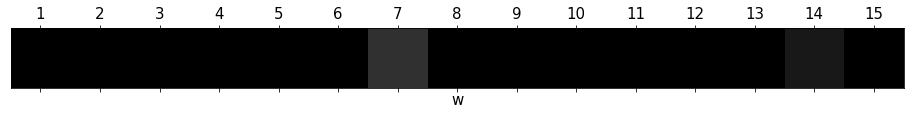

In [628]:
def make_barplot(models, title=None):
    plt.matshow((np.mean(np.exp([-(r.theta['qw'][0]/t.exp(2*r.theta['qw'][1])).cpu().detach().numpy().T for r in models]), axis=0)), vmin=0, vmax=1, norm=None, cmap='binary')
    #plt.axis('off')
    plt.yticks([])
    plt.xticks(range(15), range(1,16))
    plt.xlabel('w')
    if title is not None:
        plt.savefig(title, bbox_inches='tight')
make_barplot(result)